# Filtering of hierarchies of partitions with Higra

Higra (Hierarchical Graph Analysis) is a python library designed to apply and develop new methods for hierarchical graph analysis.

Higra's frontend is written in Python to favor ease of use and rapid developpement while it's core functions are written in c++ to ensure high performances. 

This tutorial will show you how to filter a hierarchy of partitions of an image. It is composed of 3 sections:

1. Creation of a trivial hierarchy from an image
2. Filtering of the hierarchy with various attributes
3. Visualization of the results

## Creation of a trivial hierarchy from an image

Higra integrates seamlessly with Numpy and all associated packages: we will thus rely on them for basic image manipulations.

Let's start with a bunch of imports...

In [1]:
import numpy as np
import imageio
%matplotlib inline
import matplotlib.pyplot as plt
from utils import * # tic toc imshow

import higra as hg

hg.logger_register_print_callback() # print log message to screen
hg.set_trace(False) # set it to True to get a trace of major function call


We will process a classical image from BSDS.

Image size: (481, 321)


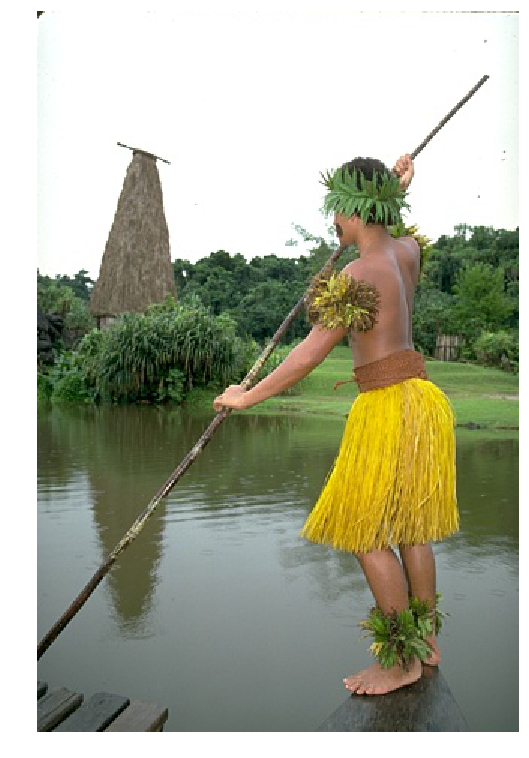

(<Figure size 481.5x721.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f9b79073d30>)

In [2]:
image = imageio.imread("data/101087.jpg")
# switch to float to avoir numerical issue with uint8
image = image.astype(np.float64)/255 
# discard the color channel
size = image.shape[:2]
print("Image size:", size)
imshow(image)

### Graph creation

The image will be represented as an edge weighted graph with a simple RGB gradient.

Let's start by creating a 4 adjacency pixel graph. 

In [3]:
graph = hg.get_4_adjacency_graph(size)

Note that at any moment we can get some help on the function with the `help` command:

In [4]:
help(hg.get_4_adjacency_graph)

Help on function get_4_adjacency_graph in module graph_image:

get_4_adjacency_graph(shape)
    Create an explicit undirected 4 adjacency graph of the given shape.
    :param shape: pair (height, width)
    :return: Graph (with attribute "shape")



Now, let's compute edge weights, Higra propose some helper functions to do this efficiently for common weighting functions:

In [5]:

edge_weights = hg.weight_graph(image, hg.WeightFunction.L2, graph)

We can plot this gradient in Khalimsky space in order to see how it looks like.

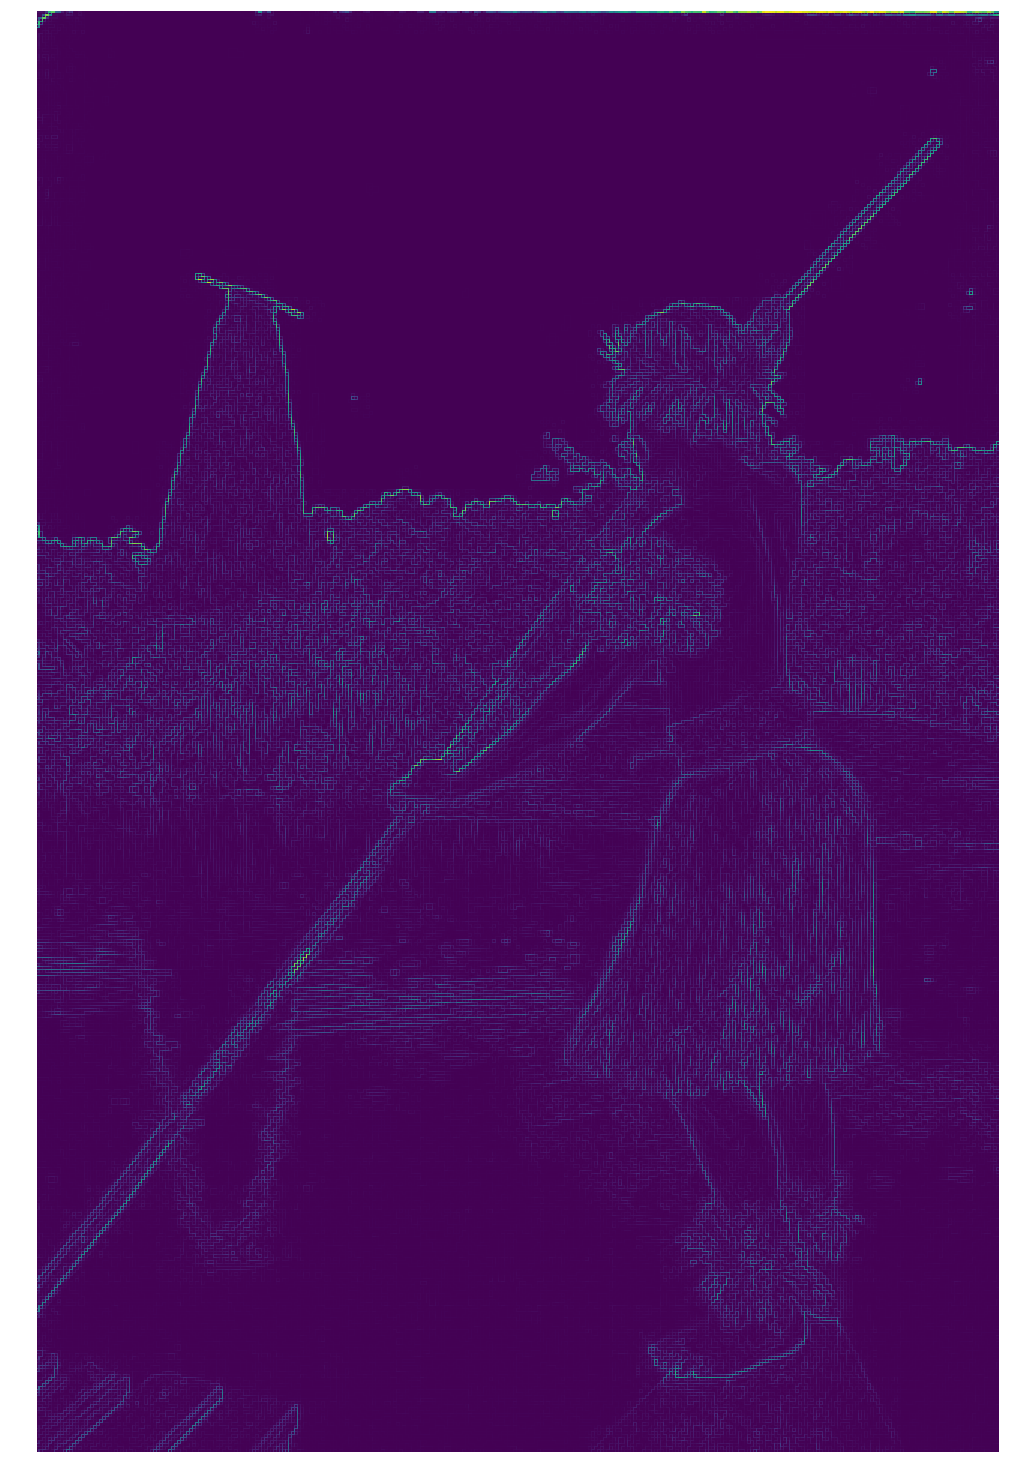

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f9b78fbd048>)

In [6]:
gradient = hg.graph_4_adjacency_2_khalimsky(edge_weights)
imshow(gradient)

Note that Higra is designed to simplify data manipulation, and we could have simply written

```
gradient = hg.contour2khalimsky(graph)
```

the value of `size` and `edge_weights` are deduced from previous processings.

### Hierarchy of partition creation

As a demo-hierarchy, we will use the canonical binary partition tree by altitude ordering from the weighted graph:

In [7]:
tree, altitudes = hg.bpt_canonical(edge_weights)

In order to visualize the hierarchy we can compute its saliency map, i.e. for each edge of the base graph, compute the altitude of the smallest vertex of the tree that contains both extremities of the edge, and display the result in Khalimsky space, as we did for the gradient.

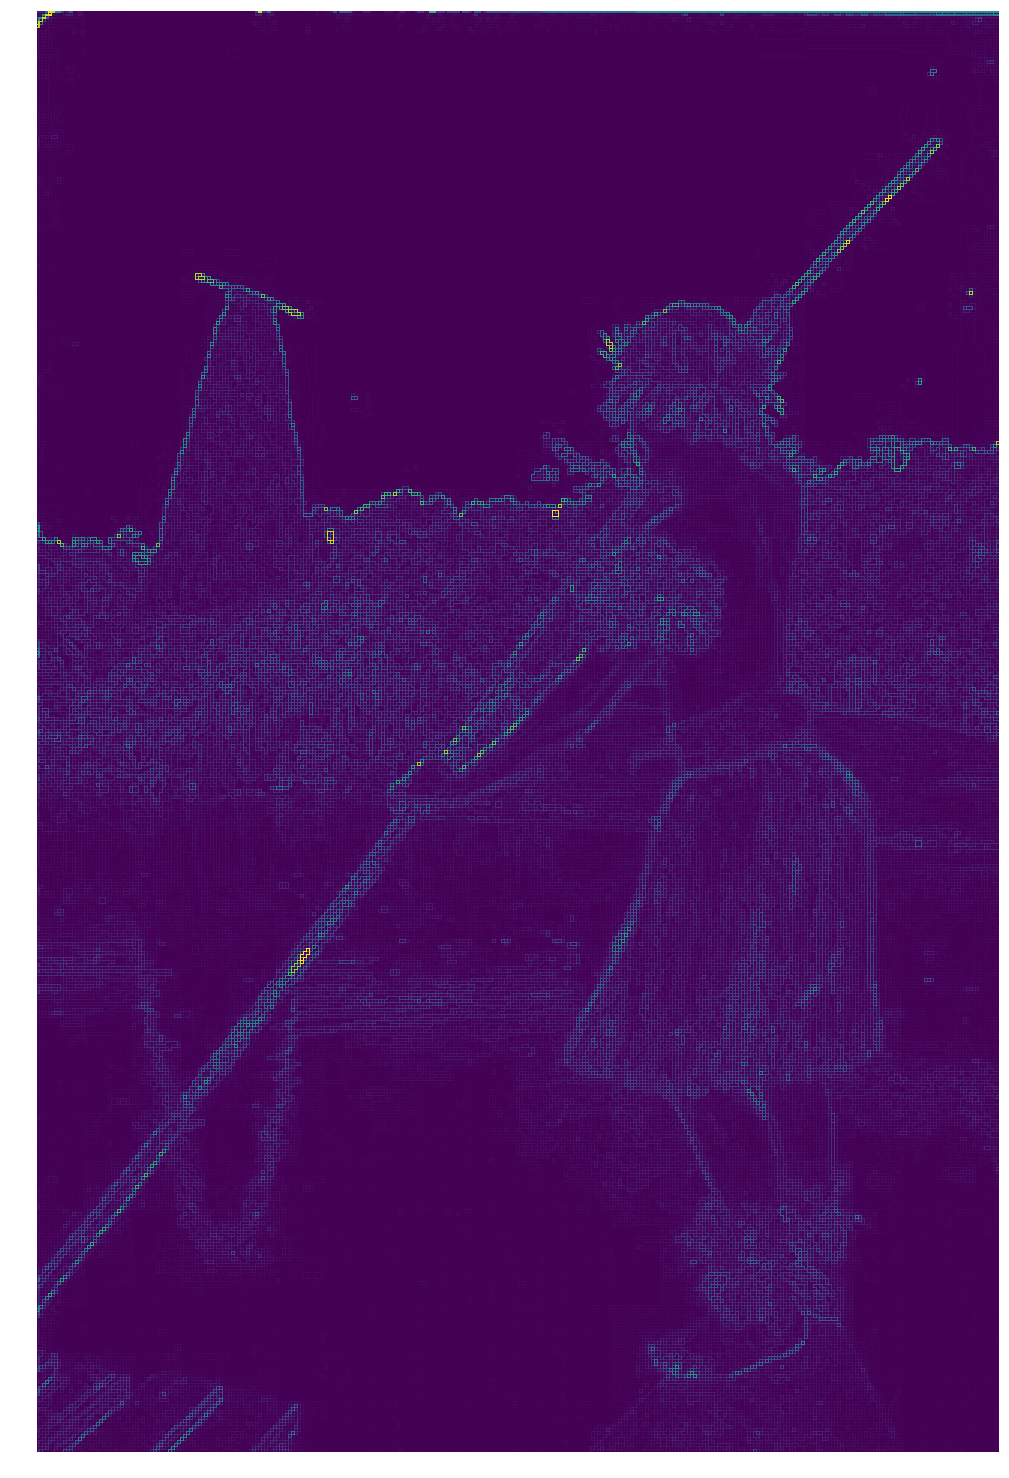

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f9b78fe3f98>)

In [8]:
saliency = hg.saliency(altitudes)
imshow(hg.graph_4_adjacency_2_khalimsky(saliency))

This is not very nice and we will see in next section how to improve this hierarchy of partitions very easily


## Hierarchy filtering

The idea of hierarchy filtering is very simple. 
Each node of the binary partition tree represent the separation between its two children.
If we identify that one of the children of a node is not relevant, according to a given measure, then the separation is not relevant either: it must be set to 0. Thus, we will erase some frontiers involving non relevant nodes which will give us a new filtered gradient from which a new hierarchy can be constructed.

### Filtering criterion

The simplest way to identify non relevant nodes is to use their size: small nodes are irrelevant.

In [9]:
area = hg.attribute_area(tree)

The frontier represented by a node will be deleted if one of its children has an area lower than a given threshold. To get this information we will compute for each node the minimum of the area of its children and compare it to the threshold.

In [10]:
min_area_children = hg.accumulate_parallel(area, hg.Accumulators.min)

Let assume that region with an area smaller than 100 pixels are not relevant

In [11]:
non_relevant_nodes = min_area_children <= 100

We can now filter our first hierachy according to this criterion

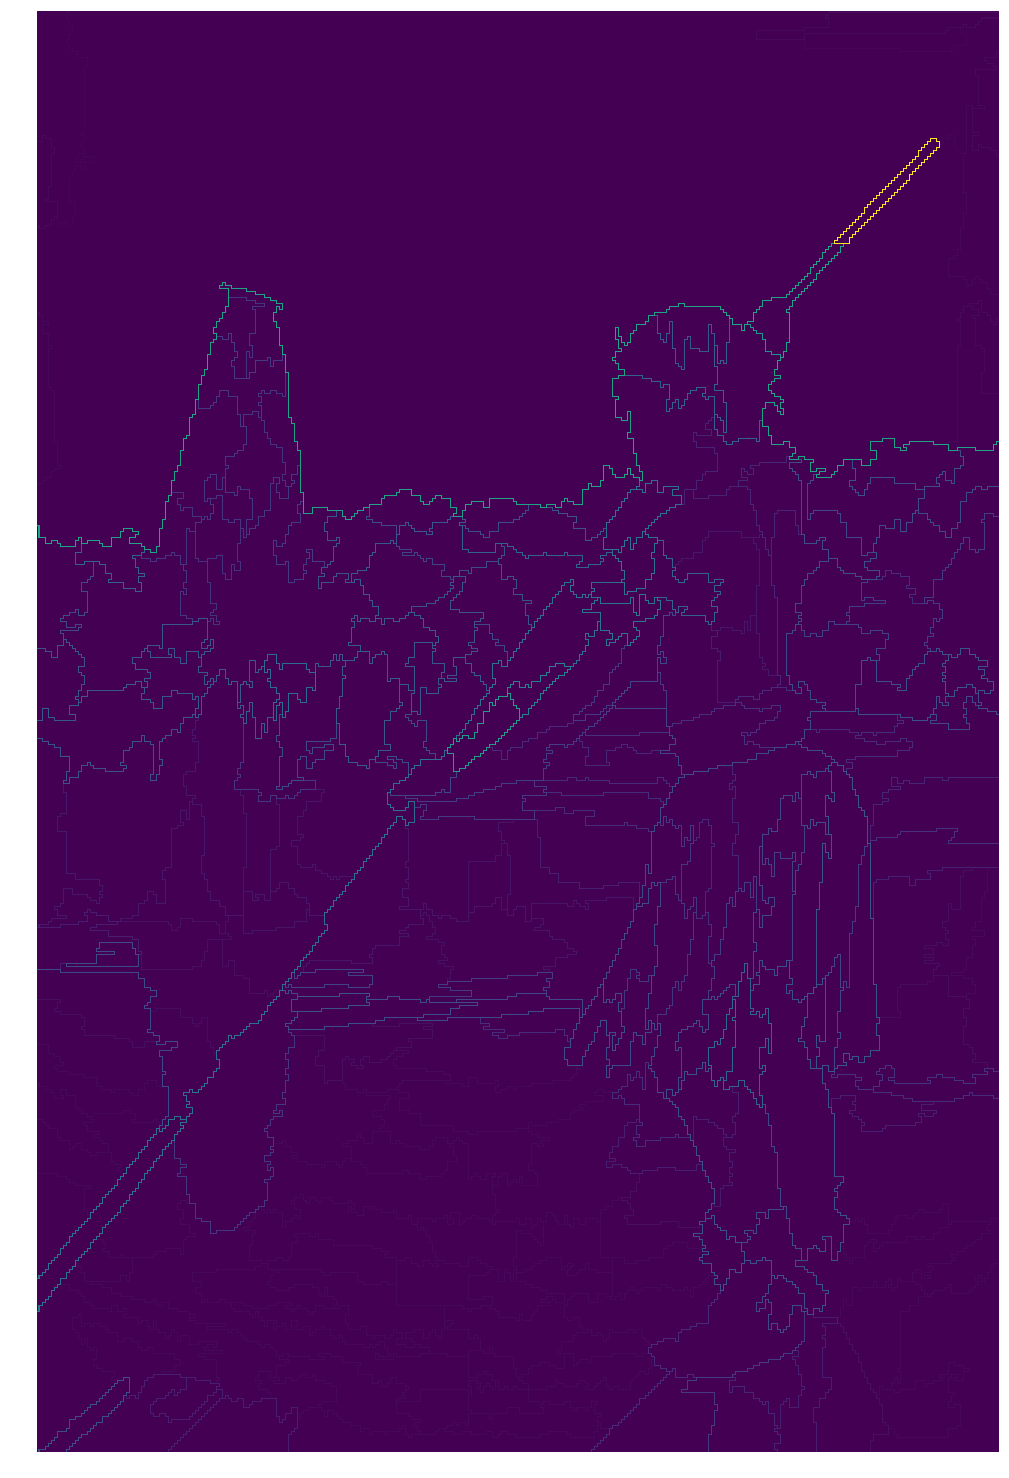

(<Figure size 961.5x1441.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f9b78f3f748>)

In [12]:
filtered_tree, filtered_altitudes = hg.filter_binary_partition_tree(altitudes, non_relevant_nodes)
imshow(hg.graph_4_adjacency_2_khalimsky(hg.saliency(filtered_altitudes)))

## Better visualization

So far, we have visualized partition hierarchies using saliency maps (or ultra-metric contour maps) in the 2D Khalimsky space.

This kind of representation can be misleading and it is sometimes interesting to visualize the different paritions composing the hierarchy.

We are going to build a small interractive plot to explore a hierarchy partition by partition.

### Horizontal cuts

A hierarchy of partitions encodes a large number of possible partitions. Here, we will restruct ourselves to the horizontal cuts of the hierarchy, i.e. partitions that corresponds to a threshold of the saliency map.

An intuitive approach to this problem is to search for the horizontal cut that contains `k` regions. Here, we compute for each node the smallest number `k` such that the region that corresponds to this node belongs to the partition in `k` regions.

In [13]:
# probably a little magic here!
# num_regions_in_horizontal_cut = [...5, 4, 3, 2]
num_regions_in_horizontal_cut = np.arange(filtered_tree.num_vertices() + 1, 1, -1)
# move values to children:
#   the two children of the root belong to the 2-partition
#   the two children of the (root-1)th node belong to the 3-partition
#   the two children of the (root-2)th node belong to the 4-partition
#   ...
num_regions_in_horizontal_cut = num_regions_in_horizontal_cut[filtered_tree.parents()]
# special case for the root
num_regions_in_horizontal_cut[-1] = 1

### Partition

A partition will be represented as an image where the color of each region is given by the mean color of the original image pixels in this region.

In [14]:
mean_color = hg.attribute_mean_weights(filtered_tree, image)

In order to get an image from a selected set of nodes from a tree, we can propagate their mean color values back to the pixels they contain. The function `hg.reconstruct_leaf_data` is here for that!

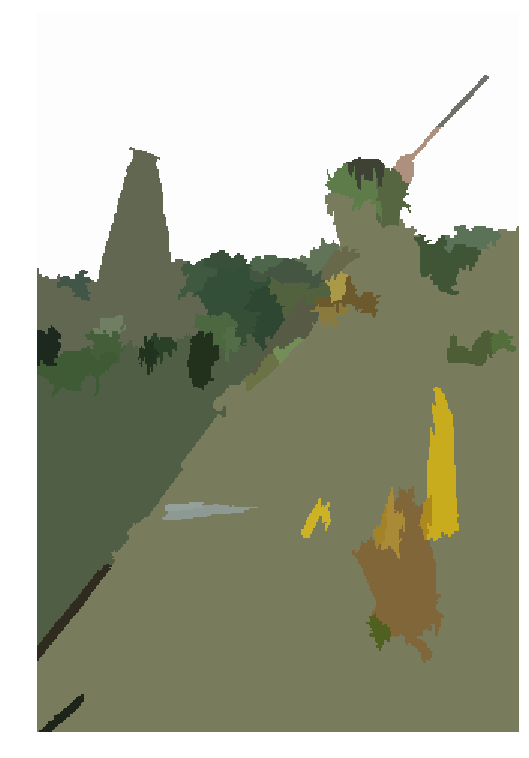

(<Figure size 481.5x721.5 with 1 Axes>,
 <matplotlib.axes._axes.Axes at 0x7f9b78e8f4e0>)

In [17]:
im = hg.reconstruct_leaf_data(mean_color, num_regions_in_horizontal_cut > 50, filtered_tree)
imshow(im)

Finally, we can use the notebook features to get a nice interractive figure:

In [16]:
from ipywidgets import  interact, widgets, IntSlider

def horizontal_cut(num_regions):
    im = hg.reconstruct_leaf_data(mean_color, num_regions_in_horizontal_cut > num_regions, filtered_tree)
    imshow(im)
    
interact(horizontal_cut, num_regions=IntSlider(value=50, min=1, max=100, step=1, continuous_update=False));

interactive(children=(IntSlider(value=50, continuous_update=False, description='num_regions', min=1), Output()…